In [7]:
import numpy as np
from dotenv import load_dotenv
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2, EstimatorV2
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit

from qc_utils import run_and_visualize, compare_circuits, quick_run


PI = np.pi

## Environment
load_dotenv(override=True)

USE_HARDWARE = True

import logging
logging.getLogger('qiskit_ibm_runtime').setLevel(logging.ERROR)


simulator = AerSimulator()
sampler_sim = SamplerV2(simulator)
estimator_sim = EstimatorV2(simulator)


if USE_HARDWARE:
    # import os
    # QiskitRuntimeService.save_account(
    #     token=os.getenv("IBM_Q_API_KEY"),
    #     set_as_default=True,
    # )

    service = QiskitRuntimeService()
    backends = service.backends()

    print("Available backends:")
    for backend in backends:
        status = "simulator" if backend.simulator else "hardware"
        print(f"  • {backend.name:25s} | {backend.num_qubits:2d} qubits | {status}")

    hardware = service.backend("ibm_kingston")
    sampler_hw = SamplerV2(hardware)
    estimator_hw = EstimatorV2(hardware)
    
    print(f"Backend: {hardware.name}")
    print(f"Basis gates: {hardware.configuration().basis_gates}")
    print(f"Coupling map: {hardware.configuration().coupling_map}")

Available backends:
  • ibm_strasbourg            | 127 qubits | hardware
  • ibm_brussels              | 127 qubits | hardware
  • ibm_aachen                | 156 qubits | hardware
  • ibm_fez                   | 156 qubits | hardware
  • ibm_pittsburgh            | 156 qubits | hardware
  • ibm_torino                | 133 qubits | hardware
  • ibm_kingston              | 156 qubits | hardware
  • ibm_marrakesh             | 156 qubits | hardware
Backend: ibm_kingston
Basis gates: ['cz', 'id', 'rz', 'sx', 'x']
Coupling map: [[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [3, 16], [4, 3], [4, 5], [5, 4], [5, 6], [6, 5], [6, 7], [7, 6], [7, 8], [7, 17], [8, 7], [8, 9], [9, 8], [9, 10], [10, 9], [10, 11], [11, 10], [11, 12], [11, 18], [12, 11], [12, 13], [13, 12], [13, 14], [14, 13], [14, 15], [15, 14], [15, 19], [16, 3], [16, 23], [17, 7], [17, 27], [18, 11], [18, 31], [19, 15], [19, 35], [20, 21], [21, 20], [21, 22], [21, 36], [22, 21], [22, 23], [23, 16], [23, 22], [23, 24], 

In [8]:
from typing import List, Tuple


def init_n_qubit(num_qubits: int, amplitudes: List[complex]):
    if 2 ** num_qubits != len(amplitudes):
        raise ValueError("The number of amplitudes must be 2 ** num_qubits")

    norm = np.sqrt(np.sum(np.abs(amplitudes) ** 2))
    norm_amp = amplitudes / norm
    
    qc = QuantumCircuit(num_qubits)
    qc.initialize(norm_amp, range(num_qubits))
    return qc


def diffusion_operator(qc: QuantumCircuit):
    num_qubits = qc.num_qubits
    qc.h(range(num_qubits))
    qc.x(range(num_qubits))

    if num_qubits == 1:
        qc.z(0)
    else:
        qc.h(num_qubits - 1)
        qc.mcx(list(range(num_qubits - 1)), num_qubits - 1)
        qc.h(num_qubits - 1)

    qc.x(range(num_qubits))
    qc.h(range(num_qubits))
    return qc

In [9]:
randoms = {0, 1, 2}

num_qubits = 4

# Random seed 설정
np.random.seed(1210)

# 랜덤하게 initial_state 생성 (크기: 2^num_qubits)
randoms_list = list(randoms)
num_states = 2 ** num_qubits
real_parts = np.random.choice(randoms_list, size=num_states)
imag_parts = np.random.choice(randoms_list, size=num_states)
initial_state = real_parts + 1j * imag_parts

# 디퓨전 연산자는 정규화된 상태에 대해 작동
norm = np.sqrt(np.sum(np.abs(initial_state) ** 2))
normalized_initial = initial_state / norm

# 평균에 대한 반사 (inversion about average)
average = np.average(normalized_initial)
expected_state = 2 * average - normalized_initial

expected_distribution = np.abs(expected_state) ** 2


qc = init_n_qubit(num_qubits, initial_state)
qc = diffusion_operator(qc)

result = run_and_visualize(qc, show_histogram=False, show_results=False, backend=hardware, show_circuit=False, shots=10000)

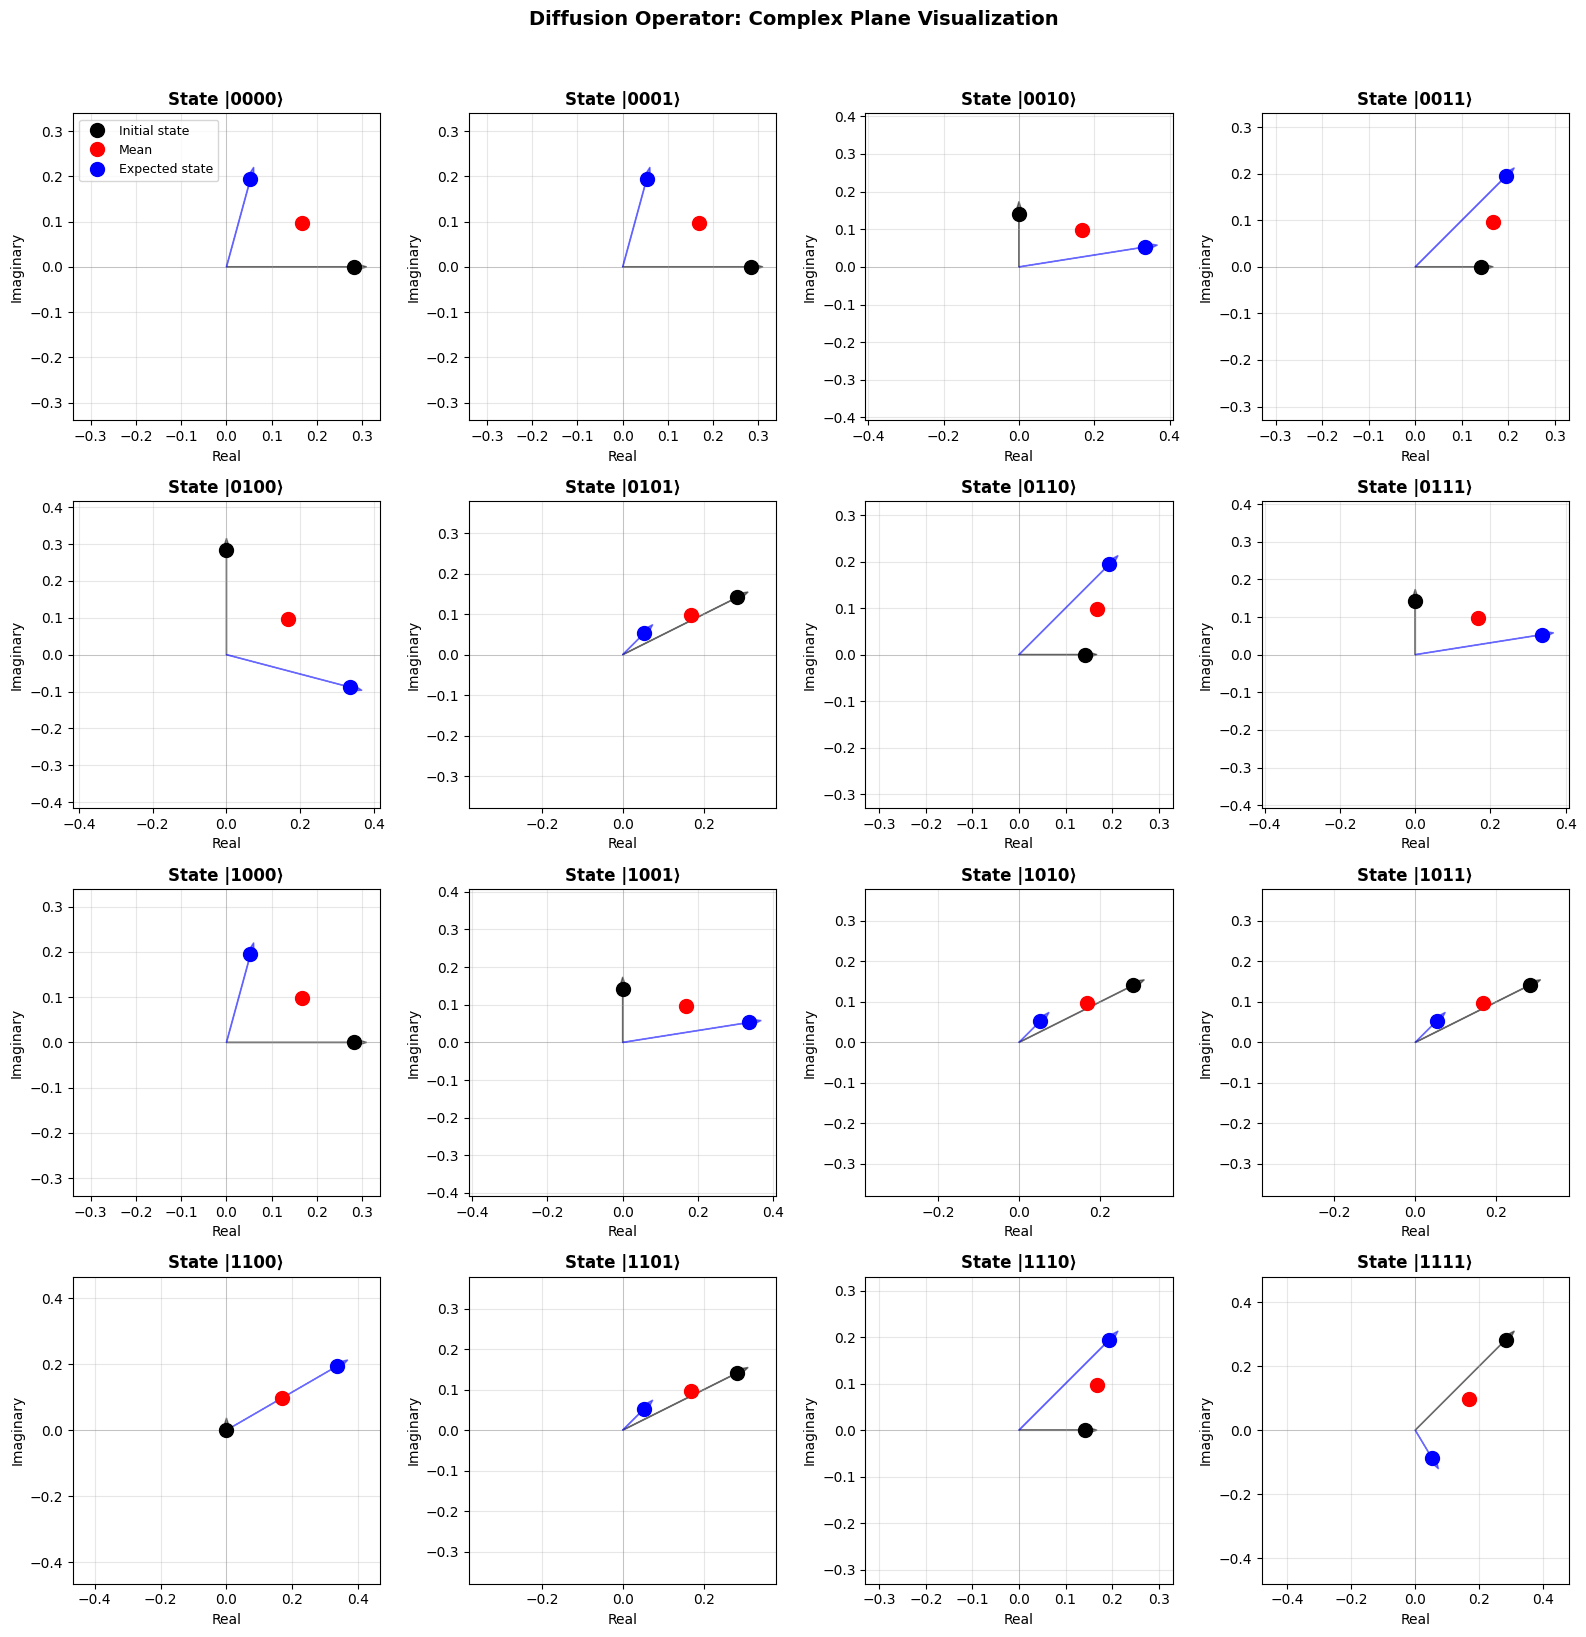

In [10]:
import matplotlib.pyplot as plt

# 1. 복소평면에 initial_state, 평균, expected_state 시각화
# 한 행에 최대 8개까지만 배치
num_states = 2**num_qubits
num_cols = min(4, num_states)
num_rows = (num_states + num_cols - 1) // num_cols  # 올림 계산

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))

# axes를 1D 배열로 변환 (기존 코드와 호환되도록)
if num_states == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# initial_state 정규화 (실제 사용되는 값)
norm = np.sqrt(np.sum(np.abs(initial_state) ** 2))
normalized_initial = initial_state / norm

# expected_state도 정규화
norm_expected = np.sqrt(np.sum(np.abs(expected_state) ** 2))
normalized_expected = expected_state / norm_expected

# 평균값 계산 (정규화된 상태의 평균)
mean_state = np.mean(normalized_initial)

for i in range(2**num_qubits):
    ax = axes[i]
    
    # 복소평면의 범위 설정
    all_values = [normalized_initial[i], mean_state, normalized_expected[i]]
    max_abs = max(abs(v) for v in all_values) * 1.2
    
    ax.set_xlim(-max_abs, max_abs)
    ax.set_ylim(-max_abs, max_abs)
    ax.axhline(y=0, color='gray', linewidth=0.5, alpha=0.5)
    ax.axvline(x=0, color='gray', linewidth=0.5, alpha=0.5)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    # 상태 |i⟩의 복소수 값들 표시
    ax.plot(normalized_initial[i].real, normalized_initial[i].imag, 
            'ko', markersize=10, label='Initial state', zorder=3)
    ax.plot(mean_state.real, mean_state.imag, 
            'ro', markersize=10, label='Mean', zorder=4)
    ax.plot(normalized_expected[i].real, normalized_expected[i].imag, 
            'bo', markersize=10, label='Expected state', zorder=5)
    
    # 원점에서 각 점까지 벡터 그리기
    ax.arrow(0, 0, normalized_initial[i].real, normalized_initial[i].imag,
             head_width=max_abs*0.05, head_length=max_abs*0.08, 
             fc='black', ec='black', alpha=0.5, zorder=1)
    ax.arrow(0, 0, normalized_expected[i].real, normalized_expected[i].imag,
             head_width=max_abs*0.05, head_length=max_abs*0.08, 
             fc='blue', ec='blue', alpha=0.5, zorder=2)
    
    # 상태 레이블
    state_label = format(i, f'0{num_qubits}b')
    ax.set_title(f'State |{state_label}⟩', fontsize=12, fontweight='bold')
    ax.set_xlabel('Real', fontsize=10)
    ax.set_ylabel('Imaginary', fontsize=10)
    
    if i == 0:
        ax.legend(loc='upper left', fontsize=9)

# 사용하지 않는 빈 서브플롯 숨기기
for i in range(num_states, len(axes)):
    axes[i].axis('off')

plt.suptitle('Diffusion Operator: Complex Plane Visualization', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


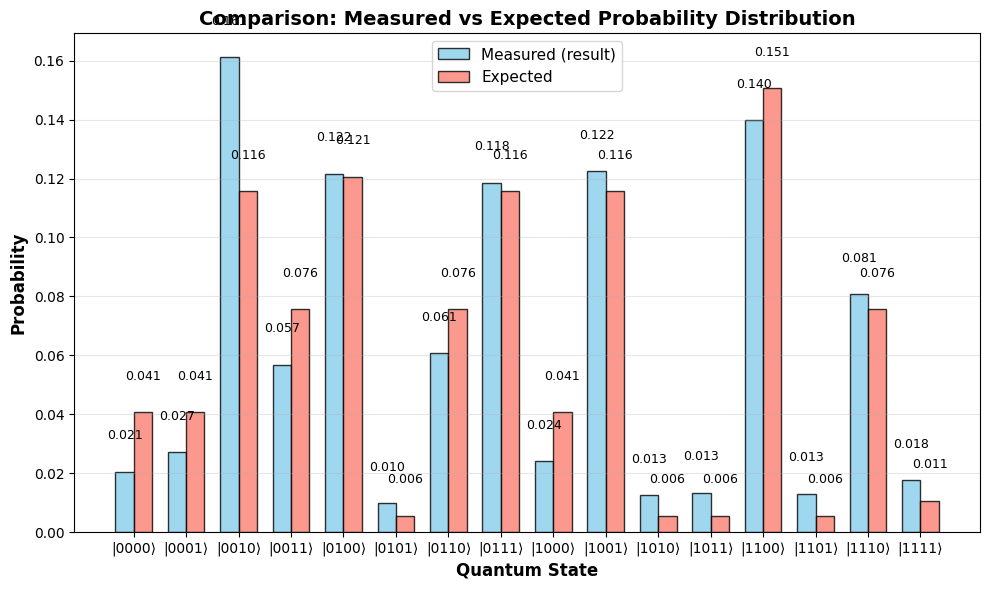


[ Probability Comparison ]
State      Measured     Expected     Difference  
--------------------------------------------------
|0000⟩       0.0205       0.0406       0.0201      
|0001⟩       0.0271       0.0406       0.0135      
|0010⟩       0.1612       0.1156       0.0456      
|0011⟩       0.0568       0.0756       0.0188      
|0100⟩       0.1216       0.1206       0.0010      
|0101⟩       0.0099       0.0056       0.0043      
|0110⟩       0.0608       0.0756       0.0148      
|0111⟩       0.1185       0.1156       0.0029      
|1000⟩       0.0241       0.0406       0.0165      
|1001⟩       0.1225       0.1156       0.0069      
|1010⟩       0.0125       0.0056       0.0069      
|1011⟩       0.0134       0.0056       0.0078      
|1100⟩       0.1398       0.1506       0.0108      
|1101⟩       0.0130       0.0056       0.0074      
|1110⟩       0.0807       0.0756       0.0051      
|1111⟩       0.0176       0.0106       0.0070      
---------------------------------------

In [11]:
# 2. result와 expected_distribution 비교 그래프
fig, ax = plt.subplots(figsize=(10, 6))

# 상태 레이블 생성
state_labels = [format(i, f'0{num_qubits}b') for i in range(2**num_qubits)]
x_pos = np.arange(len(state_labels))

# result에서 측정 확률 추출 (정규화)
# result는 하드웨어 사용 시 (ideal_counts, hw_counts) 튜플을 반환
if isinstance(result, tuple):
    ideal_counts, hw_counts = result
    measured_counts = hw_counts  # 하드웨어 측정 결과 사용
else:
    measured_counts = result
    
total_shots = sum(measured_counts.values())
measured_probs = np.zeros(2**num_qubits)

for state, count in measured_counts.items():
    # state는 '00', '01', '10', '11' 형태
    state_idx = int(state, 2)
    measured_probs[state_idx] = count / total_shots

# expected_distribution 정규화 (확률 합이 1이 되도록)
expected_probs = expected_distribution / np.sum(expected_distribution)

# 막대 그래프
width = 0.35
ax.bar(x_pos - width/2, measured_probs, width, 
       label='Measured (result)', color='skyblue', alpha=0.8, edgecolor='black')
ax.bar(x_pos + width/2, expected_probs, width, 
       label='Expected', color='salmon', alpha=0.8, edgecolor='black')

# 그래프 설정
ax.set_xlabel('Quantum State', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability', fontsize=12, fontweight='bold')
ax.set_title('Comparison: Measured vs Expected Probability Distribution', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'|{label}⟩' for label in state_labels])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# 각 막대 위에 확률값 표시
for i in x_pos:
    ax.text(i - width/2, measured_probs[i] + 0.01, 
            f'{measured_probs[i]:.3f}', 
            ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, expected_probs[i] + 0.01, 
            f'{expected_probs[i]:.3f}', 
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 수치적 비교 출력
print("\n[ Probability Comparison ]")
print(f"{'State':<10} {'Measured':<12} {'Expected':<12} {'Difference':<12}")
print("-" * 50)
for i, label in enumerate(state_labels):
    diff = abs(measured_probs[i] - expected_probs[i])
    print(f"|{label}⟩{' '*6} {measured_probs[i]:<12.4f} {expected_probs[i]:<12.4f} {diff:<12.4f}")
print("-" * 50)
print(f"Total L1 Distance: {np.sum(np.abs(measured_probs - expected_probs)):.4f}")
